In [ ]:
# install
using Pkg
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Origin.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Deformula.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/SparseMatrix.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/NMarkov.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/SymbolicDiff.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/SymbolicMarkov.jl.git"))

In [1]:
using CSV
using DataFrames
using Plots

In [2]:
include("mapqueue.jl")

get_utilization (generic function with 1 method)

In [3]:
# definition of M/M/1/K queue
@markov queue(;lambda, mu, K) begin
    @tr begin
        @s("0") => @s("1"), lambda
        @s("$K") => @s("$(K-1)"), mu
    end
    for k = 1:K-1
        @tr begin
            @s("$k") => @s("$(k+1)"), lambda
            @s("$k") => @s("$(k-1)"), mu
        end
    end
    @init begin
        @s("0"), 1
    end
    @reward :idle begin
        @s("0"), 1
    end
    for k = 1:K
        @reward :busy @s("$k"), 1
    end
    for k = 0:K
        @reward :x @s("$k"), k
    end
end

queue (generic function with 1 method)

In [4]:
# definition of QBD
@markov queue2(;B0, A0, A1, A2, K) begin
    n, _ = size(B0)
    for i=1:n
        for j=1:n
            if i != j
                @tr @s("0-$i") => @s("0-$j"), B0[i,j]
            end
            @tr @s("0-$i") => @s("1-$j"), A0[i,j]
        end
    end
    for k = 1:K-1
        for i=1:n
            for j=1:n
                if i != j
                    @tr @s("$k-$i") => @s("$k-$j"), A1[i,j]
                end
                @tr @s("$k-$i") => @s("$(k+1)-$j"), A0[i,j]
                @tr @s("$k-$i") => @s("$(k-1)-$j"), A2[i,j]
            end
        end
    end
    for i=1:n
        for j=1:n
            if i != j
                @tr @s("$K-$i") => @s("$K-$j"), A1[i,j] + A0[i,j]
            end
            @tr @s("$K-$i") => @s("$(K-1)-$j"), A2[i,j]
        end
    end
    @init begin
        @s("0-1"), 1
    end
    for i=1:n
        @reward :idle @s("0-$i"), 1
    end
    for k = 1:K
        for i=1:n
            @reward :busy @s("$k-$i"), 1
        end
    end
    for k = 0:K
        for i=1:n
            @reward :x @s("$k-$i"), k
        end
    end
end

queue2 (generic function with 1 method)

In [5]:
# define initial parameters and model (M/M/1/K queue)
env = SymbolicEnv()
@bind env begin
    lambda = 0.5
    mu = 1.0
end
model = ctmc(queue(lambda=lambda, mu=mu, K=20))

"CTMCModel(4325527049533103859)"

In [6]:
rng = MersenneTwister(1234)
results = sim(rng, model, env, 10000.0); # simulate a queue on time domain [0, 10000.0]
# tu = 0.9, to = 0.1
udat1 = get_utilization(0.9, 0.1, results);

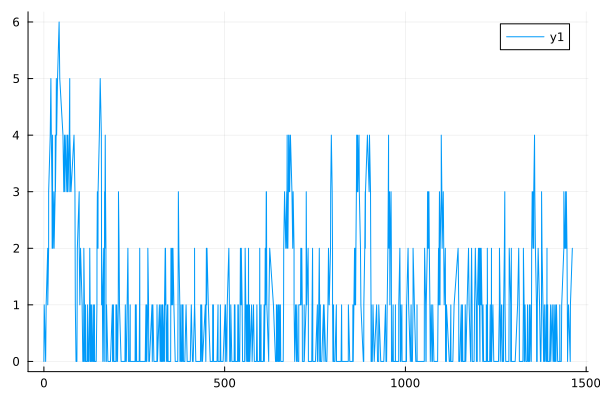

In [7]:
## number of customers
plot(results.time[1:1000], results.rewards[:x][1:1000])

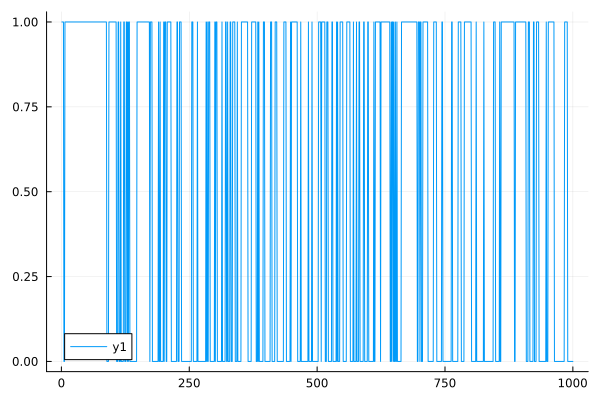

In [8]:
plot(udat1[1:1000])

In [9]:
# Define MMPP/M/1/K queue in QBD; nphase denotes the number of phases of MMPP
nphase = 2
b0 = [(i == j) ? 0 : symbolic(@s("beta_$i$j")) for i = 1:nphase, j = 1:nphase]
a0 = [(i == j) ? symbolic(@s("lambda_$i$j")) : 0 for i = 1:nphase, j = 1:nphase]
a1 = [(i == j) ? 0 : symbolic(@s("beta_$i$j")) for i = 1:nphase, j = 1:nphase]
a2 = [(i == j) ? symbolic(@s("mu")) : 0 for i = 1:nphase, j = 1:nphase]
tmp0 = [v.var for v = b0 if typeof(v) <: SymbolicVariable]
tmp1 = [v.var for v = a0 if typeof(v) <: SymbolicVariable]
tmp2 = [v.var for v = a1 if typeof(v) <: SymbolicVariable]
tmp3 = [v.var for v = a2 if typeof(v) <: SymbolicVariable]
env2 = SymbolicEnv([x=>rand() for x = [tmp0..., tmp1..., tmp2..., tmp3...]])
model2 = ctmc(queue2(B0=b0, A0=a0, A1=a1, A2=a2, K=20))

"CTMCModel(10994637810817021232)"

In [10]:
env2[:lambda_11]=0.1
env2[:lambda_22]=5.0
env2[:beta_12]=0.01
env2[:beta_21]=0.05
env2[:mu]=10.0

10.0

In [11]:
rng = MersenneTwister(1234)
results = sim(rng, model2, env2, 10000.0)
udat2 = get_utilization(0.9, 0.1, results);

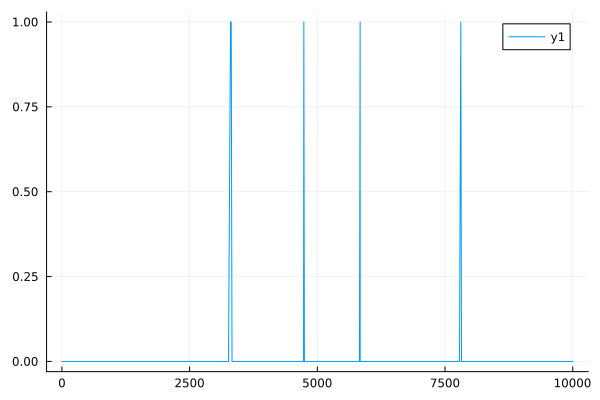

In [12]:
plot(results.time, results.rewards[:x])

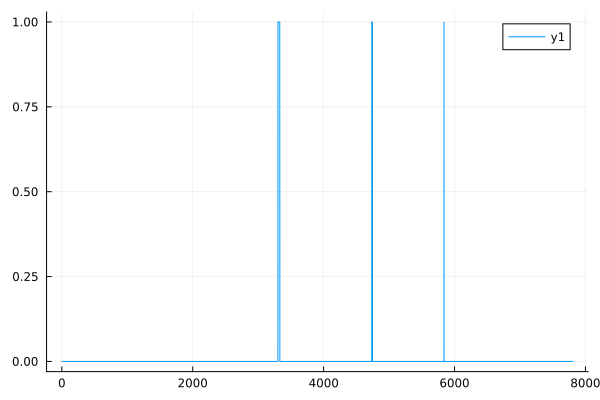

In [13]:
plot(udat2)

In [14]:
# define initial parameters and model (M/M/1/K queue)
env = SymbolicEnv()
@bind env begin
    lambda = rand()
end
model = ctmc(queue(lambda=lambda, mu=1.0, K=20))

"CTMCModel(6118014209427863677)"

In [15]:
# run estimation: tu = 0.9 and to = 0.1
emest!(model, env, udat1, 0.9, 0.1, verbose = false) # if you want to print LLFs in the algorithm, set verbose = true

(params = Dict{Symbol, Any}(:lambda => 0.42121281283410883), llf = -4969.087269336935, conv = true, iter = 12, aerror = 0.0004497146037465427, rerror = 9.050244817018059e-8)

In [16]:
# Define MMPP/M/1/K queue in QBD; nphase denotes the number of phases of MMPP
nphase = 2
b0 = [(i == j) ? 0 : symbolic(@s("beta_$i$j")) for i = 1:nphase, j = 1:nphase]
a0 = [(i == j) ? symbolic(@s("lambda_$i$j")) : 0 for i = 1:nphase, j = 1:nphase]
a1 = [(i == j) ? 0 : symbolic(@s("beta_$i$j")) for i = 1:nphase, j = 1:nphase]
a2 = [(i == j) ? 10.0 : 0 for i = 1:nphase, j = 1:nphase]
tmp0 = [v.var for v = b0 if typeof(v) <: SymbolicVariable]
tmp1 = [v.var for v = a0 if typeof(v) <: SymbolicVariable]
tmp2 = [v.var for v = a1 if typeof(v) <: SymbolicVariable]
tmp3 = [v.var for v = a2 if typeof(v) <: SymbolicVariable]
env2 = SymbolicEnv([x=>rand() for x = [tmp0..., tmp1..., tmp2..., tmp3...]])
model2 = ctmc(queue2(B0=b0, A0=a0, A1=a1, A2=a2, K=20))

"CTMCModel(15794995515278861779)"

In [17]:
# run estimation: tu = 0.9 and to = 0.1
emest!(model2, env2, udat2, 0.9, 0.1, verbose = true) # if you want to print LLFs in the algorithm, set verbose = true

iter=2 llf=-699.7167175003377 aerror=157.80337030551698 rerror=0.18402294307680891
iter=3 llf=-588.933932393678 aerror=110.78278510665973 rerror=0.15832519409057316
iter=4 llf=-510.45618142554247 aerror=78.47775096813552 rerror=0.13325391296298478
iter=5 llf=-454.4236961592342 aerror=56.03248526630824 rerror=0.10976943233369661
iter=6 llf=-414.18702512787905 aerror=40.23667103135517 rerror=0.08854439451866937
iter=7 llf=-385.19961707194835 aerror=28.9874080559307 rerror=0.06998627744792565
iter=8 llf=-364.2994849342091 aerror=20.900132137739263 rerror=0.0542579255312071
iter=9 llf=-349.24929273917 aerror=15.050192195039074 rerror=0.0413126913911423
iter=10 llf=-338.44156435771237 aerror=10.80772838145765 rerror=0.0309455984769286
iter=11 llf=-330.70775084664984 aerror=7.733813511062522 rerror=0.022851252108291125
iter=12 llf=-325.19232207983987 aerror=5.5154287668099755 rerror=0.016677651953091042
iter=13 llf=-321.2676150426637 aerror=3.9247070371761765 rerror=0.012068879769592466
iter

(params = Dict{Symbol, Any}(:lambda_22 => 24.6791118334753, :lambda_11 => 0.0004969955150088355, :beta_21 => 0.06211865939005528, :beta_12 => 0.0002903718765230041), llf = -38.2959578647761, conv = true, iter = 832, aerror = 3.827744789930421e-5, rerror = 9.99515661040624e-7)

In [18]:
env2

Dict{Symbol, Any} with 4 entries:
  :lambda_22 => 24.6791
  :lambda_11 => 0.000496996
  :beta_21   => 0.0621187
  :beta_12   => 0.000290372